In [1]:
import lasagne
import theano
import numpy as np
from lasagne.layers import *
import theano.tensor as T
from itertools import *
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def bsplines(input, polygon=(0.,1.), nb_knots=11, order=3, derivative_order=0):
    """
    Returns dictionary which contains bsplines as theano symbolic expressions over given input
    
    input : theano like input
    polygon : argument range (min_value, max_value)
    nb_knots : number of partition knots 
    order : degree of splines
    
    # examle
    x = T.vector('x', dtype='float64')
    base_splines = bsplines(x)
    plt.figure()
    for bspl in base_splines.values():
        x_test = np.arange(0., 1., 0.001)
        bspline_ex = theano.function([x], bspl)
        plt.plot(x_test, bspline_ex(x_test))

    plt.title('bsplines functions')
    """
    
    
    
    def frac(numerator, denumerator):
        if denumerator==0.:
            return 0
        return numerator / denumerator

    def indicator(left, right):
        return (T.sgn(input-left) - T.sgn(input-right)) * .5
    
    u, v = polygon
    M = order + 1 
    knots = np.concatenate([[u] * (M-1), np.linspace(u, v, nb_knots),\
            [v] * (M-1)]) 
    print('Knots shape {}'.format(knots.shape))
    bsplines = {}
    for degree in range(M):
        for i in range(0, knots.shape[0] - degree - 1):

            if degree == 0:
                if knots[i] == knots[i+1]:
                    bsplines[(i, degree)] = 0
                else:
                    bsplines[(i, degree)] = indicator(knots[i], knots[i+1])
            else:
                if degree >= order - derivative_order + 1 and derivative_order>0:
                    numerator1 = order
                    numerator2 = -order
                    
                else:
                    numerator1 = input - knots[i]
                    numerator2 = knots[i+degree+1] - input
                
                bsplines[(i, degree)] = frac(numerator1, knots[i+degree] - knots[i]) *\
                                    bsplines[(i, degree-1)] + \
                                    frac(numerator2, knots[i+degree+1] - knots[i+1]) *\
                                    bsplines[(i+1, degree-1)]

    return {k : v for k, v in bsplines.items() if k[1] == order}

Knots shape (11,)
Knots shape (13,)
Knots shape (15,)
Knots shape (17,)


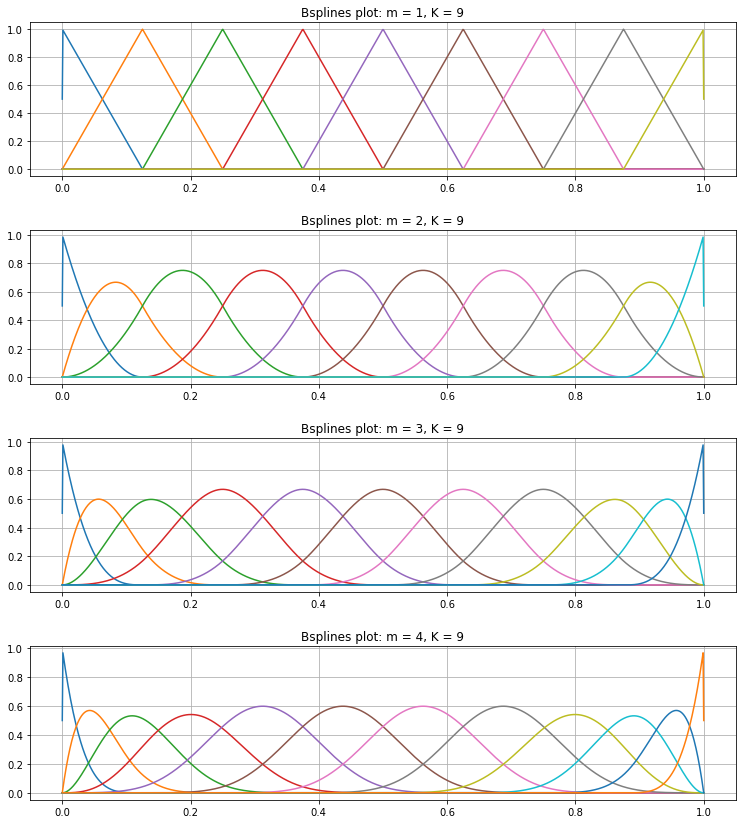

In [39]:
'''
n_row = 4
n_col = 1
plt.figure(figsize=(10 * n_col, 3 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
orders = [1, 2, 3, 4]
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    order = orders[i]
    x = T.vector()
    bspl = bsplines(x, polygon=(0.,1.), nb_knots=9, order=order, derivative_order=0)
    bspl_func = [theano.function([x], bspl_v) for bspl_v in bspl.values()]
    #plt.figure(figsize=(12, 3))
    plt.title('Bsplines plot: m = {}, K = {}'.format(order, 9))
    plt.grid()
    for j in range(len(bspl_func)):
        plt.plot(np.linspace(0, 1, 1000), bspl_func[j](np.linspace(0, 1, 1000)))
'''

In [5]:
class BsplineLayer(lasagne.layers.Layer):
    def __init__(self, incoming, polygon=(0.,1.), nb_knots=11, order=3, **kwargs):
        super(BsplineLayer, self).__init__(incoming, **kwargs)
        self.polygon = polygon
        self.nb_knots = nb_knots
        self.order = order
        
    def get_output_for(self, input, **kwargs):
        # may by this implementation is not optimal
        bspls = bsplines(input, self.polygon, self.nb_knots, self.order)
        return T.stack(bspls.values(), axis=-1)
        
    def get_output_shape_for(self, input_shape):
        return input_shape + (self.order - 1 + self.nb_knots, )

In [6]:
class MinMaxScalerLayer(lasagne.layers.Layer):
    def __init__(self, incoming, epsilon=1e-5, **kwargs):
        super(MinMaxScalerLayer, self).__init__(incoming, **kwargs)
        self.min_in = theano.shared(np.zeros(incoming.output_shape[1]))
        self.max_in = theano.shared(np.ones(incoming.output_shape[1]))        
        self.epsilon = epsilon
        
    def get_output_for(self, input, **kwargs):
        out = (input - self.min_in - self.epsilon) / (self.max_in - self.min_in + 2*self.epsilon)
        delta = self.epsilon  / (self.max_in - self.min_in + 2*self.epsilon)
        return T.maximum(delta, T.minimum(1.-delta, out))
    
    def update_scale(self, min_value, max_value):
        self.min_in.set_value(min_value)
        self.max_in.set_value(max_value)

In [ ]:

def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]
        


In [ ]:
"""
class MinMaxScalerLayer(lasagne.layers.Layer):
    def __init__(self, incoming, min_value=lasagne.init.Constant(0.), max_value=lasagne.init.Constant(1.),\
                 epsilon=1e-5, **kwargs):
        super(MinMaxScalerLayer, self).__init__(incoming, **kwargs)
        shape = [size for axis, size in enumerate(self.input_shape)]
        self.min_in = self.add_param(min_value, shape[1:], 'min',\
                                   trainable=False, regularizable=False)
        self.max_in = self.add_param(max_value, shape[1:], 'max',\
                                   trainable=False, regularizable=False)  
        self.epsilon = epsilon
        
    def get_output_for(self, input, **kwargs):
                 
        running_min_in = theano.clone(self.min_in, share_inputs=False)
        running_max_in = theano.clone(self.max_in, share_inputs=False)
        running_min_in.default_update = T.minimum(running_min_in, input.min(axis=0))     
        running_max_in.default_update = T.maximum(running_max_in, input.max(axis=0))
                 
        out = (input - self.min_in - self.epsilon) / (self.max_in - self.min_in + 2*self.epsilon)
        delta = self.epsilon  / (self.max_in - self.min_in + 2*self.epsilon)
        return T.maximum(delta, T.minimum(1.-delta, out))
    
"""